# HLC = 300

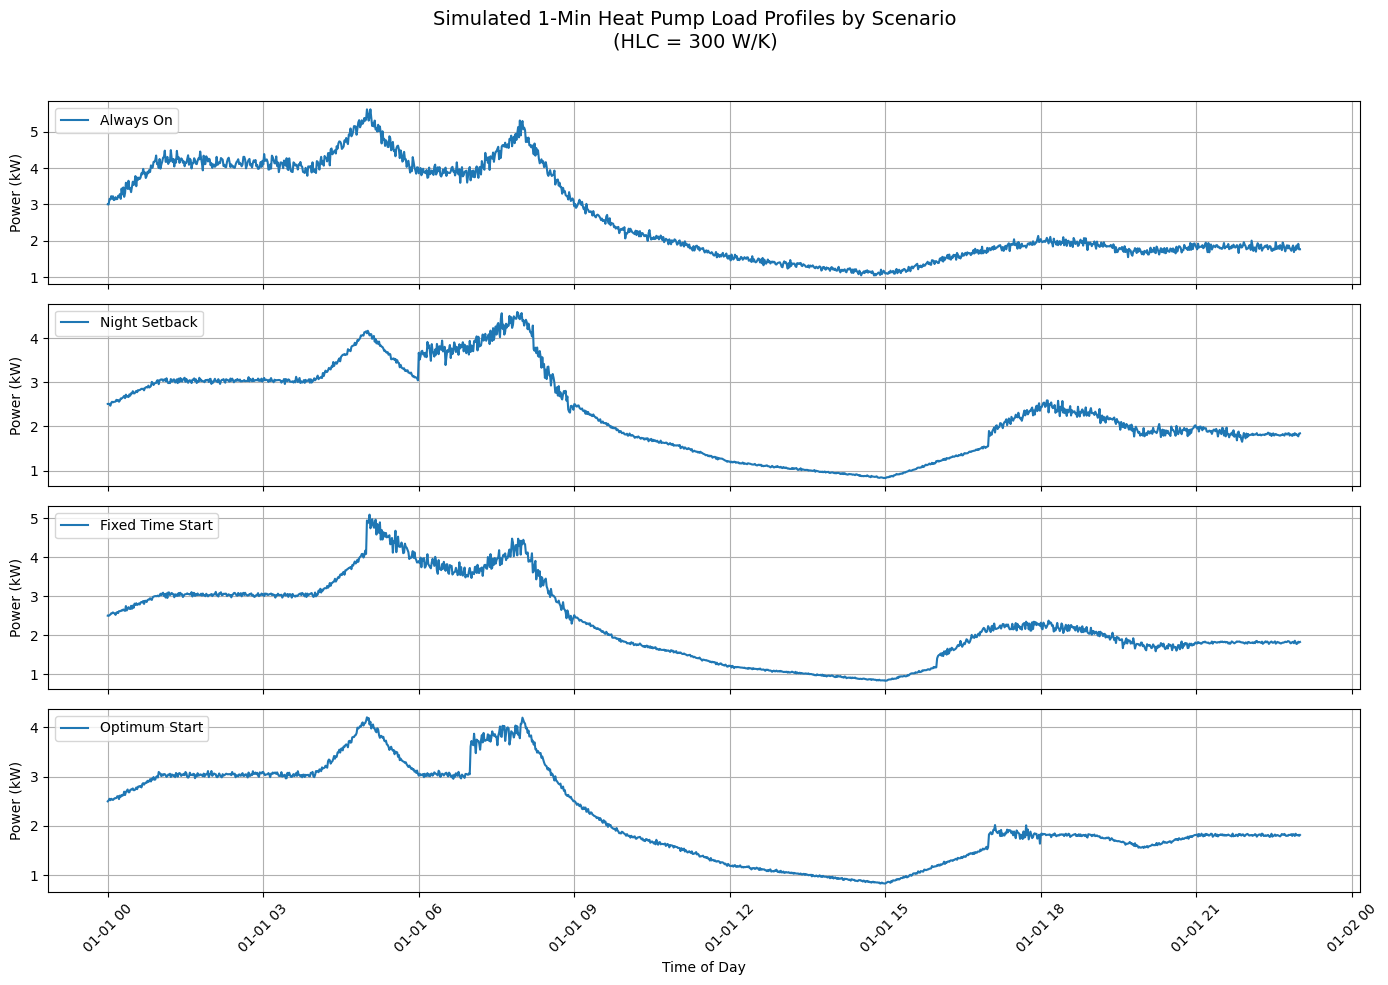

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input parameters

# Hourly outdoor temperature and COP values (24 each)
hourly_temp = np.array([
    -5, -6, -6, -6, -6, -7, -6, -6, -7, -5, -2, 0,
     3,  4,  5,  6,  3,  0, -2, -2,  0, -2, -2, -2
])
hourly_COP = np.array([
    2.64, 2.27, 2.27, 2.27, 2.27, 1.72, 2.27, 2.27,
    1.72, 2.64, 3.14, 3.26, 3.5, 3.64, 3.79, 3.96,
    3.5, 3.26, 3.14, 3.14, 3.26, 3.14, 3.14, 3.14
])

# Constants
indoor_temp_main = 21     # Comfort setpoint
indoor_temp_setback = 17  # Night setback temperature
HLC = 300                 # Heat Loss Coefficient [W/K]
time_step = 60            # Seconds
recovery_minutes = 60     # Gradual temperature ramp time

# Creating 1-minute dataframe

minute_idx = pd.date_range("1900-01-01", periods=1440, freq='1min')
df = pd.DataFrame(index=minute_idx)

hourly_idx = pd.date_range("1900-01-01", periods=24, freq='h')
df['outdoor_temp'] = pd.Series(hourly_temp, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)
df['COP'] = pd.Series(hourly_COP, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)

# Defining active periods per scenario

def get_active_mask(hours):
    return df.index.hour.isin(hours)

# Dynamic optimum start hours
def calculate_optimum_hours():
    desired_start_hours = [7, 17]  # Occupancy start times
    hours = []
    for start_hour in desired_start_hours:
        # Calculate delta T
        delta_T = indoor_temp_main - indoor_temp_setback
        cop = hourly_COP[start_hour]
        q_hourly_kWh = (delta_T * HLC * 3600) / (cop * 3.6e6)
        power_kW = q_hourly_kWh  # 1 hour
        # Approximate ramp time (longer if power is lower)
        ramp_minutes = int(np.clip(60 * q_hourly_kWh / 2, 30, 180))
        for m in range(ramp_minutes // 60 + 1):
            h = start_hour - m
            if 0 <= h < 24:
                hours.append(h)
    return sorted(list(set(hours)))

optimum_hours = calculate_optimum_hours()

scenarios = {
    'always_on': list(range(24)),
    'night_setback': list(range(6, 9)) + list(range(17, 22)),
    'fixed_time_start': list(range(5, 9)) + list(range(16, 21)),
    'optimum_start': optimum_hours
}

# Simulation

results_300 = pd.DataFrame(index=df.index)

for name, active_hours in scenarios.items():
    df_temp = df.copy()
    df_temp['active'] = get_active_mask(active_hours)
    df_temp['group'] = (df_temp['active'] != df_temp['active'].shift()).cumsum()

    # Building indoor temperature with recovery ramp
    T_indoor = pd.Series(indoor_temp_setback, index=df_temp.index, dtype='float64')

    for _, group in df_temp.groupby('group'):
        if group['active'].iloc[0]:
            n = len(group)
            ramp_len = min(recovery_minutes, n)
            ramp = np.linspace(indoor_temp_setback, indoor_temp_main, ramp_len)
            T_indoor[group.index[:ramp_len]] = ramp
            T_indoor[group.index[ramp_len:]] = indoor_temp_main

    df_temp['T_indoor'] = T_indoor
    df_temp['delta_T'] = df_temp['T_indoor'] - df_temp['outdoor_temp']
    df_temp['Q_loss_W'] = df_temp['delta_T'] * HLC
    df_temp['Q_kWh'] = (df_temp['Q_loss_W'] * time_step) / 3600000

    # Adding variation (ramp + noise) to active periods
    df_temp['weight'] = 1.0
    for _, group in df_temp.groupby('group'):
        if group['active'].iloc[0]:
            n = len(group)
            weights = np.linspace(1.2, 0.8, n) + np.random.normal(0, 0.03, n)
            df_temp.loc[group.index, 'weight'] = weights
        else:
            df_temp.loc[group.index, 'weight'] = np.random.normal(1.0, 0.01, len(group))

    # Applying weight and calculating power
    df_temp['Q_kWh_weighted'] = df_temp['Q_kWh'] * df_temp['weight']
    df_temp['elec_kWh'] = df_temp['Q_kWh_weighted'] / df_temp['COP']
    df_temp['kW'] = df_temp['elec_kWh'] * 60

    results_300[name] = df_temp['kW']

# Plotting

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)
for ax, name in zip(axs, scenarios.keys()):
    ax.plot(results_300.index, results_300[name], label=name.replace("_", " ").title())
    ax.set_ylabel("Power (kW)")
    ax.legend(loc='upper left')
    ax.grid(True)

axs[-1].set_xlabel("Time of Day")
fig.suptitle(f"Simulated 1-Min Heat Pump Load Profiles by Scenario\n(HLC = {HLC} W/K)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [2]:
daily_energy_kWh = results_300.sum() / 60  # Sum over all minutes, then dividing by 60 to get kWh
print(daily_energy_kWh)


always_on           61.934277
night_setback       53.036424
fixed_time_start    53.543711
optimum_start       50.398609
dtype: float64


# HLC = 200

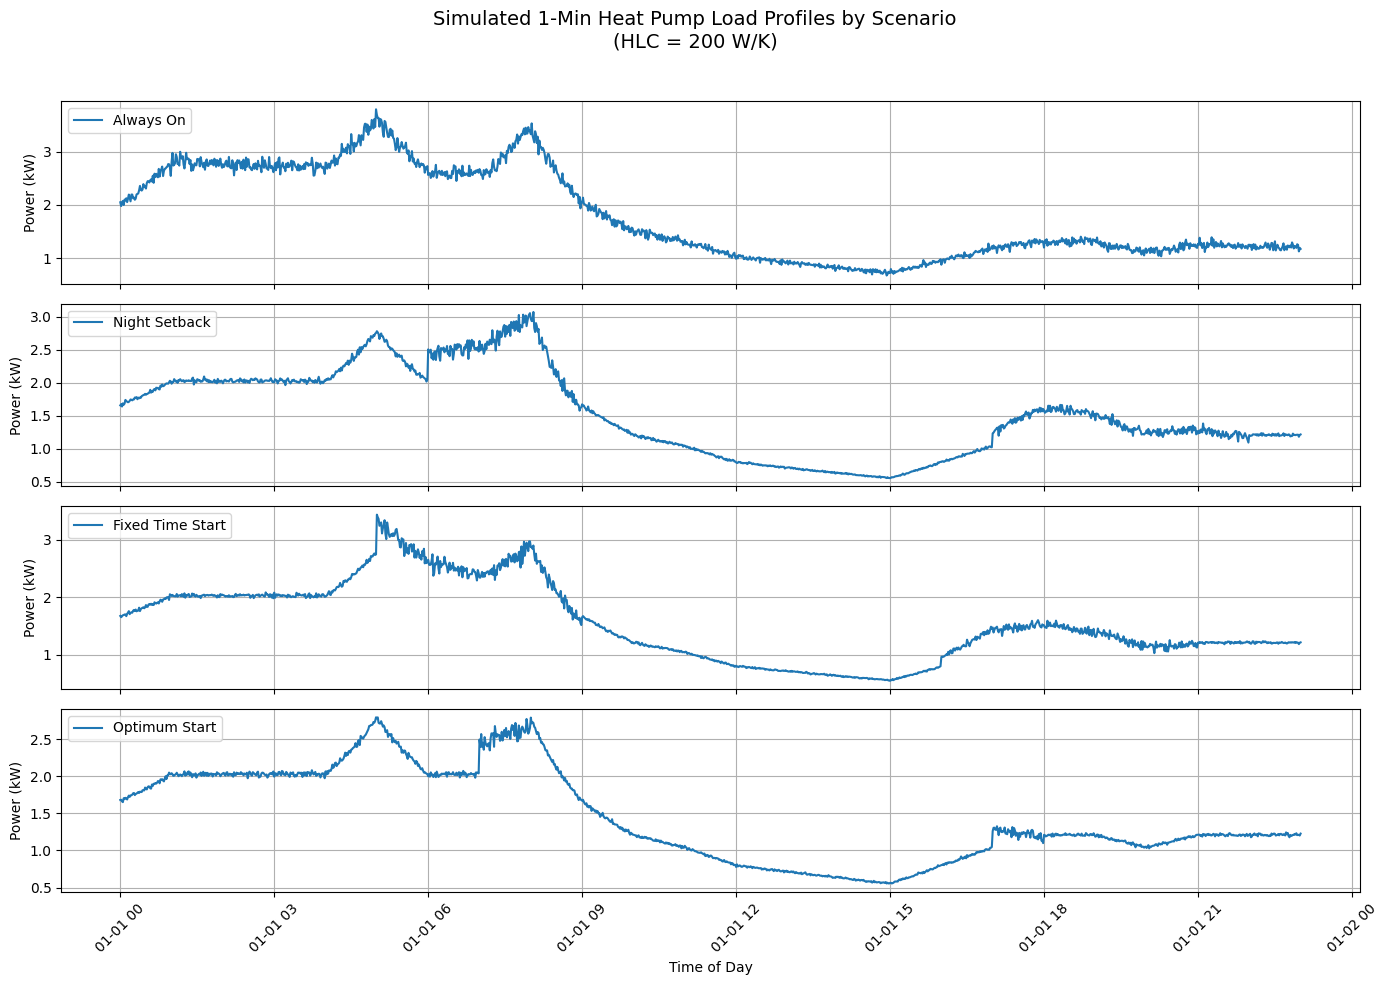

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input parameters

# Hourly outdoor temperature and COP values (24 each)
hourly_temp = np.array([
    -5, -6, -6, -6, -6, -7, -6, -6, -7, -5, -2, 0,
     3,  4,  5,  6,  3,  0, -2, -2,  0, -2, -2, -2
])
hourly_COP = np.array([
    2.64, 2.27, 2.27, 2.27, 2.27, 1.72, 2.27, 2.27,
    1.72, 2.64, 3.14, 3.26, 3.5, 3.64, 3.79, 3.96,
    3.5, 3.26, 3.14, 3.14, 3.26, 3.14, 3.14, 3.14
])

# Constants
indoor_temp_main = 21     # Comfort setpoint
indoor_temp_setback = 17  # Night setback temperature
HLC = 200                 # Heat Loss Coefficient [W/K]
time_step = 60            # Seconds
recovery_minutes = 60     # Gradual temperature ramp time

# Creating 1-minute dataframe

minute_idx = pd.date_range("1900-01-01", periods=1440, freq='1min')
df = pd.DataFrame(index=minute_idx)

hourly_idx = pd.date_range("1900-01-01", periods=24, freq='h')
df['outdoor_temp'] = pd.Series(hourly_temp, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)
df['COP'] = pd.Series(hourly_COP, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)

# Defining active periods per scenario

def get_active_mask(hours):
    return df.index.hour.isin(hours)

# Dynamic optimum start hours
def calculate_optimum_hours():
    desired_start_hours = [7, 17]  # Occupancy start times
    hours = []
    for start_hour in desired_start_hours:
        # Calculate delta T
        delta_T = indoor_temp_main - indoor_temp_setback
        cop = hourly_COP[start_hour]
        q_hourly_kWh = (delta_T * HLC * 3600) / (cop * 3.6e6)
        power_kW = q_hourly_kWh  # 1 hour
        # Approximate ramp time (longer if power is lower)
        ramp_minutes = int(np.clip(60 * q_hourly_kWh / 2, 30, 180))
        for m in range(ramp_minutes // 60 + 1):
            h = start_hour - m
            if 0 <= h < 24:
                hours.append(h)
    return sorted(list(set(hours)))

optimum_hours = calculate_optimum_hours()

scenarios = {
    'always_on': list(range(24)),
    'night_setback': list(range(6, 9)) + list(range(17, 22)),
    'fixed_time_start': list(range(5, 9)) + list(range(16, 21)),
    'optimum_start': optimum_hours
}

# Simulation

results_200 = pd.DataFrame(index=df.index)

for name, active_hours in scenarios.items():
    df_temp = df.copy()
    df_temp['active'] = get_active_mask(active_hours)
    df_temp['group'] = (df_temp['active'] != df_temp['active'].shift()).cumsum()

    # Building indoor temperature with recovery ramp
    T_indoor = pd.Series(indoor_temp_setback, index=df_temp.index, dtype='float64')

    for _, group in df_temp.groupby('group'):
        if group['active'].iloc[0]:
            n = len(group)
            ramp_len = min(recovery_minutes, n)
            ramp = np.linspace(indoor_temp_setback, indoor_temp_main, ramp_len)
            T_indoor[group.index[:ramp_len]] = ramp
            T_indoor[group.index[ramp_len:]] = indoor_temp_main

    df_temp['T_indoor'] = T_indoor
    df_temp['delta_T'] = df_temp['T_indoor'] - df_temp['outdoor_temp']
    df_temp['Q_loss_W'] = df_temp['delta_T'] * HLC
    df_temp['Q_kWh'] = (df_temp['Q_loss_W'] * time_step) / 3600000

    # Adding variation (ramp + noise) to active periods
    df_temp['weight'] = 1.0
    for _, group in df_temp.groupby('group'):
        if group['active'].iloc[0]:
            n = len(group)
            weights = np.linspace(1.2, 0.8, n) + np.random.normal(0, 0.03, n)
            df_temp.loc[group.index, 'weight'] = weights
        else:
            df_temp.loc[group.index, 'weight'] = np.random.normal(1.0, 0.01, len(group))

    # Applying weight and calculating power
    df_temp['Q_kWh_weighted'] = df_temp['Q_kWh'] * df_temp['weight']
    df_temp['elec_kWh'] = df_temp['Q_kWh_weighted'] / df_temp['COP']
    df_temp['kW'] = df_temp['elec_kWh'] * 60

    results_200[name] = df_temp['kW']

# Plotting

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)
for ax, name in zip(axs, scenarios.keys()):
    ax.plot(results_200.index, results_200[name], label=name.replace("_", " ").title())
    ax.set_ylabel("Power (kW)")
    ax.legend(loc='upper left')
    ax.grid(True)

axs[-1].set_xlabel("Time of Day")
fig.suptitle(f"Simulated 1-Min Heat Pump Load Profiles by Scenario\n(HLC = {HLC} W/K)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [4]:
daily_energy_kWh = results_200.sum() / 60  # Sum over all minutes, then dividing by 60 to get kWh
print(daily_energy_kWh)

always_on           41.372649
night_setback       35.337258
fixed_time_start    35.668811
optimum_start       33.627413
dtype: float64


# HLC = 100

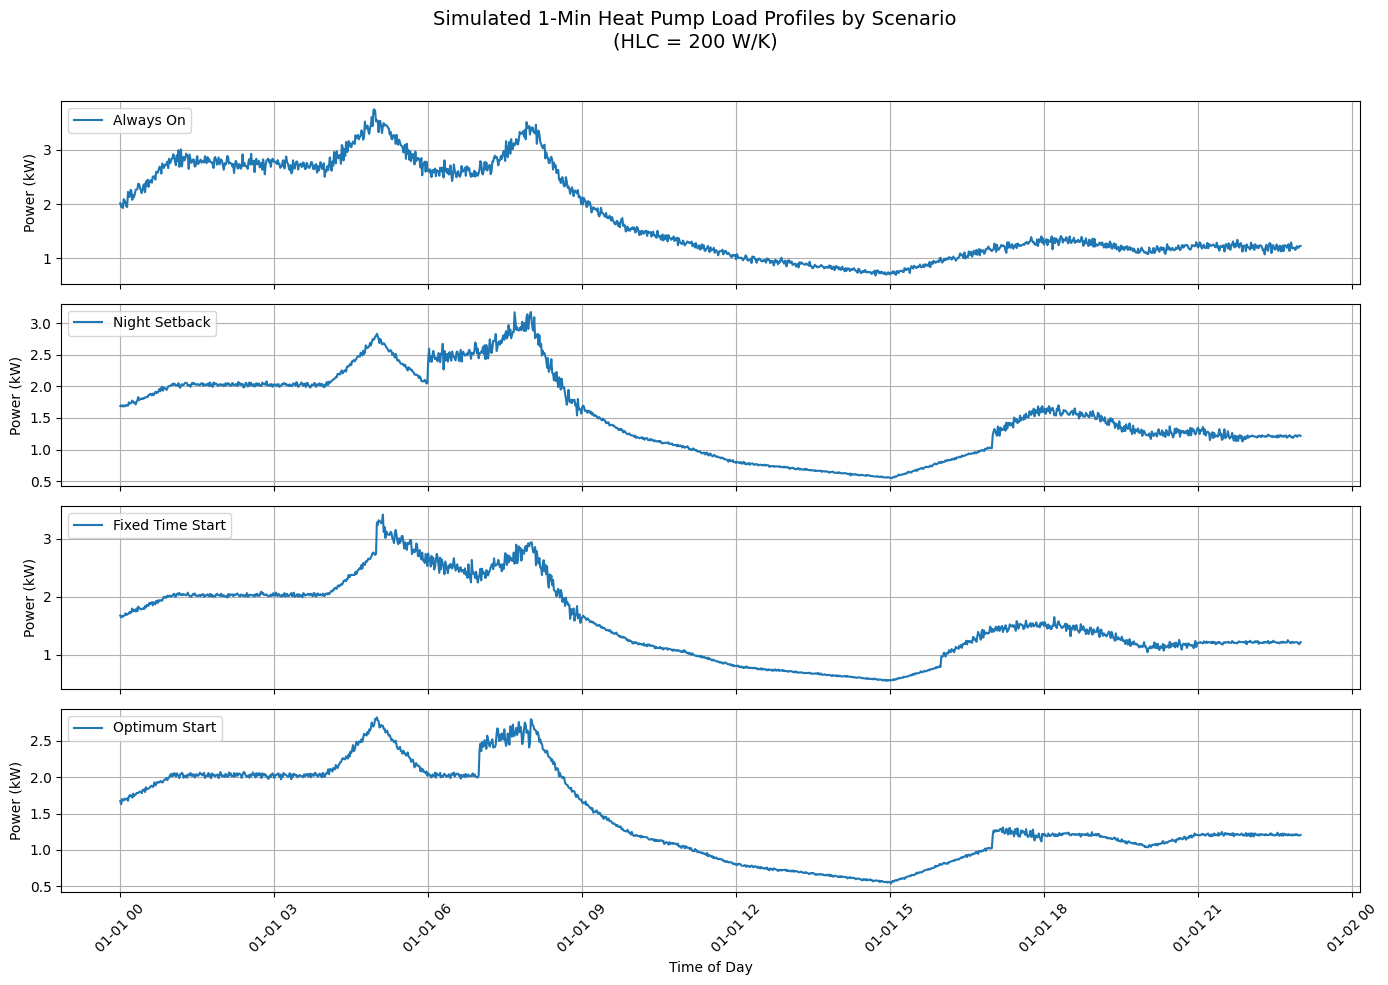

In [5]:
# Input parameters

# Hourly outdoor temperature and COP values (24 each)
hourly_temp = np.array([
    -5, -6, -6, -6, -6, -7, -6, -6, -7, -5, -2, 0,
     3,  4,  5,  6,  3,  0, -2, -2,  0, -2, -2, -2
])
hourly_COP = np.array([
    2.64, 2.27, 2.27, 2.27, 2.27, 1.72, 2.27, 2.27,
    1.72, 2.64, 3.14, 3.26, 3.5, 3.64, 3.79, 3.96,
    3.5, 3.26, 3.14, 3.14, 3.26, 3.14, 3.14, 3.14
])

# Constants
indoor_temp_main = 21     # Comfort setpoint
indoor_temp_setback = 17  # Night setback temperature
HLC = 200                 # Heat Loss Coefficient [W/K]
time_step = 60            # Seconds
recovery_minutes = 60     # Gradual temperature ramp time

# Creating 1-minute dataframe

minute_idx = pd.date_range("1900-01-01", periods=1440, freq='1min')
df = pd.DataFrame(index=minute_idx)

hourly_idx = pd.date_range("1900-01-01", periods=24, freq='h')
df['outdoor_temp'] = pd.Series(hourly_temp, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)
df['COP'] = pd.Series(hourly_COP, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)

# Defining active periods per scenario

def get_active_mask(hours):
    return df.index.hour.isin(hours)

# Dynamic optimum start hours
def calculate_optimum_hours():
    desired_start_hours = [7, 17]  # Occupancy start times
    hours = []
    for start_hour in desired_start_hours:
        # Calculate delta T
        delta_T = indoor_temp_main - indoor_temp_setback
        cop = hourly_COP[start_hour]
        q_hourly_kWh = (delta_T * HLC * 3600) / (cop * 3.6e6)
        power_kW = q_hourly_kWh  # 1 hour
        # Approximate ramp time (longer if power is lower)
        ramp_minutes = int(np.clip(60 * q_hourly_kWh / 2, 30, 180))
        for m in range(ramp_minutes // 60 + 1):
            h = start_hour - m
            if 0 <= h < 24:
                hours.append(h)
    return sorted(list(set(hours)))

optimum_hours = calculate_optimum_hours()

scenarios = {
    'always_on': list(range(24)),
    'night_setback': list(range(6, 9)) + list(range(17, 22)),
    'fixed_time_start': list(range(5, 9)) + list(range(16, 21)),
    'optimum_start': optimum_hours
}

# Simulation

results_100 = pd.DataFrame(index=df.index)

for name, active_hours in scenarios.items():
    df_temp = df.copy()
    df_temp['active'] = get_active_mask(active_hours)
    df_temp['group'] = (df_temp['active'] != df_temp['active'].shift()).cumsum()

    # Building indoor temperature with recovery ramp
    T_indoor = pd.Series(indoor_temp_setback, index=df_temp.index, dtype='float64')

    for _, group in df_temp.groupby('group'):
        if group['active'].iloc[0]:
            n = len(group)
            ramp_len = min(recovery_minutes, n)
            ramp = np.linspace(indoor_temp_setback, indoor_temp_main, ramp_len)
            T_indoor[group.index[:ramp_len]] = ramp
            T_indoor[group.index[ramp_len:]] = indoor_temp_main

    df_temp['T_indoor'] = T_indoor
    df_temp['delta_T'] = df_temp['T_indoor'] - df_temp['outdoor_temp']
    df_temp['Q_loss_W'] = df_temp['delta_T'] * HLC
    df_temp['Q_kWh'] = (df_temp['Q_loss_W'] * time_step) / 3600000

    # Adding variation (ramp + noise) to active periods
    df_temp['weight'] = 1.0
    for _, group in df_temp.groupby('group'):
        if group['active'].iloc[0]:
            n = len(group)
            weights = np.linspace(1.2, 0.8, n) + np.random.normal(0, 0.03, n)
            df_temp.loc[group.index, 'weight'] = weights
        else:
            df_temp.loc[group.index, 'weight'] = np.random.normal(1.0, 0.01, len(group))

    # Applying weight and calculating power
    df_temp['Q_kWh_weighted'] = df_temp['Q_kWh'] * df_temp['weight']
    df_temp['elec_kWh'] = df_temp['Q_kWh_weighted'] / df_temp['COP']
    df_temp['kW'] = df_temp['elec_kWh'] * 60

    results_100[name] = df_temp['kW']

# Plotting

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)
for ax, name in zip(axs, scenarios.keys()):
    ax.plot(results_100.index, results_100[name], label=name.replace("_", " ").title())
    ax.set_ylabel("Power (kW)")
    ax.legend(loc='upper left')
    ax.grid(True)

axs[-1].set_xlabel("Time of Day")
fig.suptitle(f"Simulated 1-Min Heat Pump Load Profiles by Scenario\n(HLC = {HLC} W/K)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [6]:
daily_energy_kWh = results_100.sum() / 60  # Sum over all minutes, then dividing by 60 to get kWh
print(daily_energy_kWh)

always_on           41.342199
night_setback       35.368647
fixed_time_start    35.725518
optimum_start       33.619966
dtype: float64


In [7]:
results_100.head()

,always_on,night_setback,fixed_time_start,optimum_start
1900-01-01 00:00:00,2.017659,1.688687,1.675681,1.672411
1900-01-01 00:01:00,1.951684,1.701267,1.641602,1.629537
1900-01-01 00:02:00,1.993805,1.681915,1.667996,1.699507
1900-01-01 00:03:00,1.927613,1.697213,1.657641,1.683903
1900-01-01 00:04:00,2.091557,1.681720,1.666996,1.681635


In [8]:
results_300.to_csv('HP_load_poor.csv')
results_200.to_csv('HP_load_average.csv')
results_100.to_csv('HP_load_good.csv')